## Multi Label(Head, Branch) Classifier
- 하나의 Convolution 모델에서 3개의 FC Layer 브랜치를 만들어보자

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


- 기존 데이터셋 (train_df)
- 기존 데이터셋에서 데이터 개수가 부족한 클래스들에 대해 albumentation 데이터를 추가 (aug_df)
- train_df와 aug_df 를 합쳐서 데이터 불균형을 어느정도 해소하는 것이 목표

In [2]:
train_df = pd.read_csv('train_label.csv')
aug_df = pd.read_csv('augment.csv')
aug_df2 = pd.read_csv('augment2.csv') # 2/27 추가
aug_df3 = pd.read_csv('augment3.csv') # 2/27 추가

concat_df = pd.concat([train_df,aug_df], ignore_index=True)
concat_df2 = pd.concat([concat_df,aug_df2], ignore_index=True)


df = pd.concat([concat_df2,aug_df3], ignore_index=True) # 최종 df


print(len(df))

# wear, incorrect, normal 3가지 클래스로 변경
# 0~5, 6~11, 12~17끼리 묶는다
df_mask = df.copy()

def mask_label(x):
    if x in [0,1,2,3,4,5]:
        return 0    # wear
    elif x in [6,7,8,9,10,11]:
        return 1    # incorrect
    else:
        return 2    # not wear

df_mask['label'] = df_mask['label'].apply(mask_label)

# 남성, 여성 2가지 클래스로 변경
# [0,1,2,6,7,8,12,13,14], [3,4,5,9,10,11,15,16,17]
df_gender = df.copy()

def gender_label(x):
    if x in [0,1,2,6,7,8,12,13,14]:
        return 0    # male
    else:
        return 1    # female

df_gender['label'] = df_gender['label'].apply(gender_label)

# 청년, 중년, 장년 3가지 클래스로 변경
# [0,3,6,9,12,15], [1,4,7,10,13,16], [2,5,8,11,14,17]
df_age = df.copy()

def age_label(x):
    if x in [0,3,6,9,12,15]:
        return 0    # young
    elif x in [1,4,7,10,13,16]:
        return 1    # middle
    else:
        return 2    # old

df_age['label'] = df_age['label'].apply(age_label)


41289


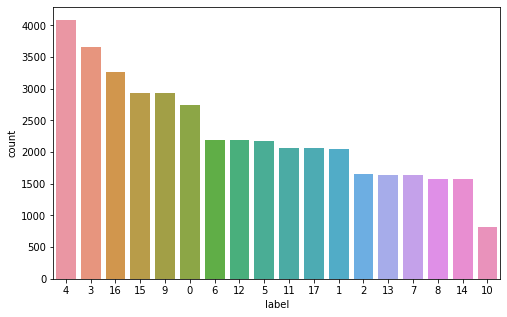

In [3]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='label', order = df['label'].value_counts().index)
plt.show()

### Dataset  정의
- mask, gender, age 별로 label 나눔

In [4]:
class MultiBranchDataset(Dataset):
    def __init__(self, df, df_mask, df_gender, df_age, transforms):
        self.df = df
        self.image_data = self.df['path']   # x data, 이미지
        self.image_label = self.df['label'] # y data, 레이블

        self.mask_label = df_mask['label']
        self.gender_label = df_gender['label']
        self.age_label = df_age['label']

        self.transform = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        img_path = self.df['path'].iloc[idx]
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)
        
        dict_label = {
            'class' : self.image_label[idx],
            'mask' : self.mask_label[idx],
            'gender' : self.gender_label[idx],
            'age' : self.age_label[idx]
        }

        return img, dict_label

In [61]:
# # 데이터셋 준비
# df = pd.read_csv('train_label.csv')
# df_mask = pd.read_csv('df_mask.csv')
# df_gender = pd.read_csv('df_gender.csv')
# df_age = pd.read_csv('df_age.csv')

(14175, 3) (4725, 3)


#### Transform & Dataset
- 모든 데이터를 한방에 학습할 때와
- train과 valid를 split할 때의 코드가 다름 (train, valid를 쪼갠거와 동일한 mask, gender, age 레이블링이 필요함)

In [5]:
# Transform Compose
data_transform = torchvision.transforms.Compose([
    transforms.CenterCrop(350),
    # torchvision.transforms.Resize((350,350),Image.BILINEAR),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.2,0.2,0.2)),
])

# train data 한방에 학습시키는 경우
train_dataset = MultiBranchDataset(df, df_mask, df_gender, df_age, data_transform)



In [12]:
# 데이터를 split할 경우, 기존 데이터(train, valid)와 이에 해당하는 mask, age, gender 레이블을 모두 맞춰야함
from sklearn.model_selection import train_test_split
train, valid = train_test_split(df, test_size = 0.25, shuffle=True, stratify=df['label'], random_state=1234)
print(train.shape, valid.shape)

train_ind = train.index.tolist()
valid_ind = valid.index.tolist()

train_df_mask = df_mask.loc[train_ind]
valid_df_mask = df_mask.loc[valid_ind]

train_df_gender = df_gender.loc[train_ind]
valid_df_gender = df_gender.loc[valid_ind]

train_df_age = df_age.loc[train_ind]
valid_df_age = df_age.loc[valid_ind]


(26646, 3) (8883, 3)


### DataLoader
- 여기서 3개로 나눌 필요가 없음
- 모델 train에서 loss를 따로 나눌 것임

In [6]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


데이터로더의 label 부분을 보면 mask, gender, age별로 배치사이즈에 맞게 레이블 정보가 담아짐

In [7]:
next(iter(train_dataloader))[1]

{'class': tensor([ 5,  0, 16,  2, 10, 16,  1,  3, 11,  3,  6,  0,  3, 15, 14, 14,  8, 16,
          6,  9,  8,  7,  2, 14, 17,  4, 10,  0, 16,  4, 16,  8,  1,  5,  4,  1,
          1,  0,  5,  1,  9, 16, 12,  7, 17, 17, 13, 15, 12,  9,  3,  3,  5, 15,
         13, 16,  1,  5,  5,  7, 15, 15,  4,  3, 10,  2,  3, 13, 15, 12,  1, 17,
         12,  5,  3, 11, 16, 13,  4, 11, 15,  5, 15,  9,  2,  1, 10,  3,  8,  4,
          3, 10, 15,  3, 14,  5, 15, 15, 16,  8,  3,  2,  5,  9,  6,  3,  9, 14,
         14,  4, 16,  5, 15,  9, 15,  5, 15, 10,  7,  6, 17,  6, 10,  3, 16, 15,
          9, 15]),
 'mask': tensor([0, 0, 2, 0, 1, 2, 0, 0, 1, 0, 1, 0, 0, 2, 2, 2, 1, 2, 1, 1, 1, 1, 0, 2,
         2, 0, 1, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 2, 2, 2,
         2, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 2,
         2, 0, 0, 1, 2, 2, 0, 1, 2, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 2, 0, 2, 0,
         2, 2, 2, 1, 0, 0, 0, 1, 1, 0, 1, 2, 2, 0, 2, 0, 2, 1, 2, 0, 2, 1

#### cutmix 함수

In [8]:
import random
# 랜덤 위치에서 패치 만들지 않고, 가로 세로로 절반만 자르는 함수
def half_bbox(size, lam):
    W = size[2]
    H = size[3]

    # 가로로 절반(왼쪽, 오른쪽), 세로로 절반(위쪽, 아랫쪽)
    idx = random.randint(0,1)

    bbx1 = [0, 0]
    bby1 = [0, H//2]
    
    bbx2 = [W, W]
    bby2 = [H//2, H]

    return bbx1[idx], bby1[idx], bbx2[idx], bby2[idx]

### Multi Label Classifier Model
- Multi Sample Dropout

In [9]:
class MultiBranchModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.base_model = torchvision.models.resnet18(pretrained=True)
        # classifier 전까지 사용
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])

        self.mask = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(512, 3, bias=True)
        )
        self.gender = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(512, 2, bias=True)
        )
        self.age = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(512, 3, bias=True)
        )
        

    def forward(self, x):
        x = self.base_model(x)
        # print(x.shape)

        x = torch.flatten(x, start_dim=1)
        # print('22: ', x.shape)

        return {
            'mask': self.mask(x),
            'gender': self.gender(x),
            'age': self.age(x)
        }

    # Loss 함수 구현 부분
    def get_loss(self, net_output, ground_truth):
        mask_loss = F.cross_entropy(net_output['mask'], ground_truth['mask'].to(device))
        gender_loss = F.cross_entropy(net_output['gender'], ground_truth['gender'].to(device))
        age_loss = F.cross_entropy(net_output['age'], ground_truth['age'].to(device))

        loss = mask_loss + gender_loss + age_loss

        return loss #, {'mask' : mask_loss, 'gender' : gender_loss, 'age' : age_loss}

In [17]:
model = MultiBranchModel()
x = torch.ones((1,3,224,224))
out = model.forward(x)

## Train

In [11]:
model = MultiBranchModel().to(device)

LEARNING_RATE = 0.001
NUM_EPOCH = 5
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss Function은 Model Class에서 구현함

# model = torch.nn.DataParallel(model)


In [ ]:
# moblienetv2
# torchvision.models.mobilenet_v2(pretrained=True)

#### 모든 데이터 Train만 진행

In [23]:

for epoch in range(NUM_EPOCH):
    running_acc = 0
    total_loss = 0
    for i, (images, labels) in enumerate(train_dataloader):

        images = images.to(device)
        labels = labels # dict타입이라서 get_loss 함수 안에서 따로 cuda로 올림

        optimizer.zero_grad()

        output = model(images)


        pred_mask = torch.argmax(output['mask'], dim=-1)
        pred_gender = torch.argmax(output['gender'], dim=-1)
        pred_age = torch.argmax(output['age'], dim=-1)
        pred_class = (pred_mask * 6) + (pred_gender * 3) + (pred_age)

        loss_train = model.get_loss(output, labels)
        total_loss += loss_train.item()

        loss_train.backward()       # gradient를 계산
        optimizer.step()      # gradient descent
    

        running_acc += torch.sum(pred_class == labels['class'].to(device))

    
        if i % 100 == 0:
            print('Epoch: {}, i: {},Loss: {:.6f}'.format(epoch, i, loss_train.item()))
            print(f'{i}번 배치: {running_acc}/{(i+1)*batch_size}, 정확도: {running_acc/((i+1)*64)}')
    
    epoch_acc = running_acc / len(train_dataloader.dataset)
    print('Final Accuracy :', epoch_acc)


Epoch: 0, i: 0,Loss: 3.306540
0번 배치: 3/64, 정확도: 0.046875
Epoch: 0, i: 100,Loss: 0.271943
100번 배치: 10959/6464, 정확도: 1.6953898668289185
Epoch: 0, i: 200,Loss: 0.114967
200번 배치: 22720/12864, 정확도: 1.7661690711975098
Epoch: 0, i: 300,Loss: 0.121596
300번 배치: 34808/19264, 정확도: 1.8068935871124268
Final Accuracy : tensor(0.9101, device='cuda:0')
Epoch: 1, i: 0,Loss: 0.072116
0번 배치: 125/64, 정확도: 1.953125
Epoch: 1, i: 100,Loss: 0.057322
100번 배치: 12563/6464, 정확도: 1.9435334205627441
Epoch: 1, i: 200,Loss: 0.214528
200번 배치: 24997/12864, 정확도: 1.9431747198104858
Epoch: 1, i: 300,Loss: 0.043553
300번 배치: 37391/19264, 정확도: 1.940977931022644
Final Accuracy : tensor(0.9699, device='cuda:0')
Epoch: 2, i: 0,Loss: 0.046657
0번 배치: 127/64, 정확도: 1.984375
Epoch: 2, i: 100,Loss: 0.021976
100번 배치: 12713/6464, 정확도: 1.9667388200759888
Epoch: 2, i: 200,Loss: 0.018715
200번 배치: 25320/12864, 정확도: 1.9682835340499878
Epoch: 2, i: 300,Loss: 0.047603
300번 배치: 37976/19264, 정확도: 1.9713454246520996
Final Accuracy : tensor(0.985

### cutmix 추가한 모델

In [12]:

for epoch in range(NUM_EPOCH):
    running_acc = 0
    total_loss = 0
    for i, (images, labels) in enumerate(train_dataloader):

        images = images.to(device)
        labels = labels # dict타입이라서 get_loss 함수 안에서 따로 cuda로 올림

        optimizer.zero_grad()

        ### cutmix
        r = np.random.rand(1)
        if r <= 0.5:
            lam = 1/2
            rand_index = torch.randperm(images.size()[0])
            target_a = labels

            # mask, gender, age 별로 labels[rand_index] 만들고 다시 합쳐서 get_loss에 넣어준다?
            # target_b = labels[rand_index]
            target_mask = labels['mask'][rand_index]
            target_gender = labels['gender'][rand_index]
            target_age = labels['age'][rand_index]

            target_b = {'mask' : target_mask, 'gender' : target_gender, 'age' : target_age}
            bbx1, bby1, bbx2, bby2 = half_bbox(images.size(), lam)
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]


            output = model(images)

            pred_mask = torch.argmax(output['mask'], dim=-1)
            pred_gender = torch.argmax(output['gender'], dim=-1)
            pred_age = torch.argmax(output['age'], dim=-1)
            pred_class = (pred_mask * 6) + (pred_gender * 3) + (pred_age)

            loss_train = model.get_loss(output, target_a) * lam + model.get_loss(output, target_b) * (1. - lam)
            total_loss += loss_train.item()

            loss_train.backward()       # gradient를 계산
            optimizer.step()      # gradient descent
        
        else:
            output = model(images)

            pred_mask = torch.argmax(output['mask'], dim=-1)
            pred_gender = torch.argmax(output['gender'], dim=-1)
            pred_age = torch.argmax(output['age'], dim=-1)
            pred_class = (pred_mask * 6) + (pred_gender * 3) + (pred_age)

            loss_train = model.get_loss(output, labels)
            total_loss += loss_train.item()

            loss_train.backward()       # gradient를 계산
            optimizer.step()      # gradient descent


        running_acc += torch.sum(pred_class == labels['class'].to(device))

    
        if i % 100 == 0:
            print('Epoch: {}, i: {},Loss: {:.6f}'.format(epoch, i, loss_train.item()))
            print(f'{i}번 배치: {running_acc}/{(i+1)*batch_size}, 정확도: {running_acc/((i+1)*batch_size)}')
    
    epoch_acc = running_acc / len(train_dataloader.dataset)
    print('Final Accuracy :', epoch_acc)


Epoch: 0, i: 0,Loss: 3.317724
0번 배치: 6/128, 정확도: 0.046875
Epoch: 0, i: 100,Loss: 1.708813
100번 배치: 7498/12928, 정확도: 0.5799814462661743
Epoch: 0, i: 200,Loss: 0.279735
200번 배치: 15662/25728, 정확도: 0.6087530851364136
Epoch: 0, i: 300,Loss: 1.504243
300번 배치: 23803/38528, 정확도: 0.6178104281425476
Final Accuracy : tensor(0.6231, device='cuda:0')
Epoch: 1, i: 0,Loss: 1.546771
0번 배치: 43/128, 정확도: 0.3359375
Epoch: 1, i: 100,Loss: 1.486984
100번 배치: 8013/12928, 정확도: 0.6198174357414246
Epoch: 1, i: 200,Loss: 0.107381
200번 배치: 16378/25728, 정확도: 0.6365826725959778
Epoch: 1, i: 300,Loss: 1.466144
300번 배치: 24623/38528, 정확도: 0.6390936374664307
Final Accuracy : tensor(0.6404, device='cuda:0')
Epoch: 2, i: 0,Loss: 0.146239
0번 배치: 121/128, 정확도: 0.9453125
Epoch: 2, i: 100,Loss: 1.627552
100번 배치: 8618/12928, 정확도: 0.6666150689125061
Epoch: 2, i: 200,Loss: 0.102581
200번 배치: 16509/25728, 정확도: 0.6416743993759155
Epoch: 2, i: 300,Loss: 1.465384
300번 배치: 24914/38528, 정확도: 0.6466465592384338
Final Accuracy : tensor(

---
### 테스트(Evaluation) 중, mask, gender, age별 output 뽑아내기
- 최종 클래스 예측(18개)으로 변환
- mask : 0, 1, 2 (wear, incorrect, not wear)
- gender : 0, 1  (male, female)
- age : 0, 1, 2  (young, middle, old)
- class : (mask * 6) + (gender * 3) + (age)

## Testing

In [14]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)


        return image

    def __len__(self):
        return len(self.img_paths)

In [15]:
# meta 데이터와 이미지 경로를 불러옵니다.
test_dir = '/opt/ml/input/data/eval'
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

dataset = TestDataset(image_paths, data_transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
test_model = model.to(device)
test_model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        output = test_model(images)

        pred_mask = torch.argmax(output['mask'], dim=-1)
        pred_gender = torch.argmax(output['gender'], dim=-1)
        pred_age = torch.argmax(output['age'], dim=-1)
        pred_class = (pred_mask * 6) + (pred_gender * 3) + (pred_age)

        all_predictions.extend(pred_class.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission11.csv'), index=False)
print('test inference is done!')

test inference is done!
